# 서울시 따릉이 대여량 예측 경진대회
#### < python을 이용하여 선택한 변수들로 대여량 예측하고 qt5로 구현해보기 >

### 1. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf

from sklearn.linear_model import LinearRegression      # 선형회귀
from sklearn.ensemble import RandomForestRegressor     # 랜덤포레스트
from xgboost import XGBRegressor, plot_tree, plot_importance

%matplotlib inline
warnings.simplefilter("ignore")

### 2. 데이터 셋 구성하기

#### 1) 데이터 불러오기

In [2]:
train = pd.read_csv("C:/Users/user13/Documents/Study/따릉이/train.csv")
test = pd.read_csv("C:/Users/user13/Documents/Study/따릉이/test.csv")
submission = pd.read_csv("C:/Users/user13/Documents/Study/따릉이/submission.csv")

#### 2) 데이터 확인

In [3]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [4]:
train.shape, test.shape, submission.shape

((1459, 11), (715, 10), (715, 2))

### 3. 전처리

#### 1) 결측치 처리
* hour_bef_precipitation : 최빈값(0)으로 처리
* 나머지 열 : 평균값으로 처리

In [5]:
# train 데이터셋 결측치 처리
train['hour_bef_precipitation'].fillna('0', inplace=True)
train.fillna(train.mean(), inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   object 
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 125.5+ KB


In [6]:
# test 데이터셋 결측치 처리
test['hour_bef_precipitation'].fillna('0', inplace=True)
test.fillna(test.mean(), inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    715 non-null    float64
 3   hour_bef_precipitation  715 non-null    object 
 4   hour_bef_windspeed      715 non-null    float64
 5   hour_bef_humidity       715 non-null    float64
 6   hour_bef_visibility     715 non-null    float64
 7   hour_bef_ozone          715 non-null    float64
 8   hour_bef_pm10           715 non-null    float64
 9   hour_bef_pm2.5          715 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 56.0+ KB


#### 3) 변수 정의

In [7]:
x_train = train.drop(['id','count'], axis=1)
y_train = train['count']
x_test = test.drop(['id'], axis=1)

In [8]:
x_train.shape, y_train.shape, x_test.shape

((1459, 9), (1459,), (715, 9))

### 3. 학습

In [9]:
# 평가지표
def get_nmae(pred, y):
    nmae = np.mean(abs(pred-y)/y)
    return nmae

#### 1) LinearRegression

In [10]:
# 모델 생성
model_LR = LinearRegression()

# 학습
model_LR.fit(x_train, y_train)

# 예측값
y_pred_LR = model_LR.predict(x_test)

# 평가
y_pred = model_LR.predict(x_train)
LR = get_nmae(y_pred, y_train)
print('NMAE :',LR)

NMAE : 1.2364909188776283


#### 2) RandomForestRegressor

In [16]:
# 모델 생성
model_RF100 = RandomForestRegressor(n_estimators=100, random_state=0)

# 모델 학습
model_RF100.fit(x_train, y_train)

# 예측값
y_pred_RF100 = model_RF100.predict(x_test)

# 평가
y_pred = model_RF100.predict(x_train)
RF100 = get_nmae(y_pred, y_train)
print('NMAE :',RF100)

NMAE : 0.2744164912585406


#### 3) XGBRegressor

In [24]:
# 모델 생성
model_XGB = XGBRegressor(max_depth = 4, n_estimators = 500)

# 모델 학습
model_XGB.fit(x_train.astype(np.float32), y_train.astype(np.float32))

# 예측값
y_pred_XGB = model_XGB.predict(x_test.astype(np.float32))

# 평가
y_pred = model_XGB.predict(x_train.astype(np.float32))
XGB = get_nmae(y_pred.astype(np.float32), y_train.astype(np.float32))
print('NMAE :',XGB)

NMAE : 0.04001384


### 4. 결과

In [25]:
submission['count'] = (y_pred_LR + y_pred_RF100 + y_pred_XGB) / 3
submission['count_LR'] = y_pred_LR
submission['count_RF100'] = y_pred_RF100
submission['count_XGB'] = y_pred_XGB
submission

,id,count,count_LR,count_RF100,count_XGB
0,0,102.685271,103.623271,89.68,114.752541
1,1,217.129345,237.486142,216.82,197.081894
2,2,52.201163,54.478812,77.50,24.624678
3,4,61.344418,110.166314,28.87,44.996941
4,5,76.269290,91.486274,78.03,59.291595
...,...,...,...,...,...
710,2148,66.490379,108.097052,62.65,28.724085
711,2149,62.489835,69.752711,71.98,45.736794
712,2165,124.792291,134.666608,125.94,113.770264
713,2166,162.297388,188.775872,156.70,141.416290


In [26]:
result = submission.drop(['id'], axis=1)
result

,count,count_LR,count_RF100,count_XGB
0,102.685271,103.623271,89.68,114.752541
1,217.129345,237.486142,216.82,197.081894
2,52.201163,54.478812,77.50,24.624678
3,61.344418,110.166314,28.87,44.996941
4,76.269290,91.486274,78.03,59.291595
...,...,...,...,...
710,66.490379,108.097052,62.65,28.724085
711,62.489835,69.752711,71.98,45.736794
712,124.792291,134.666608,125.94,113.770264
713,162.297388,188.775872,156.70,141.416290


<AxesSubplot: >

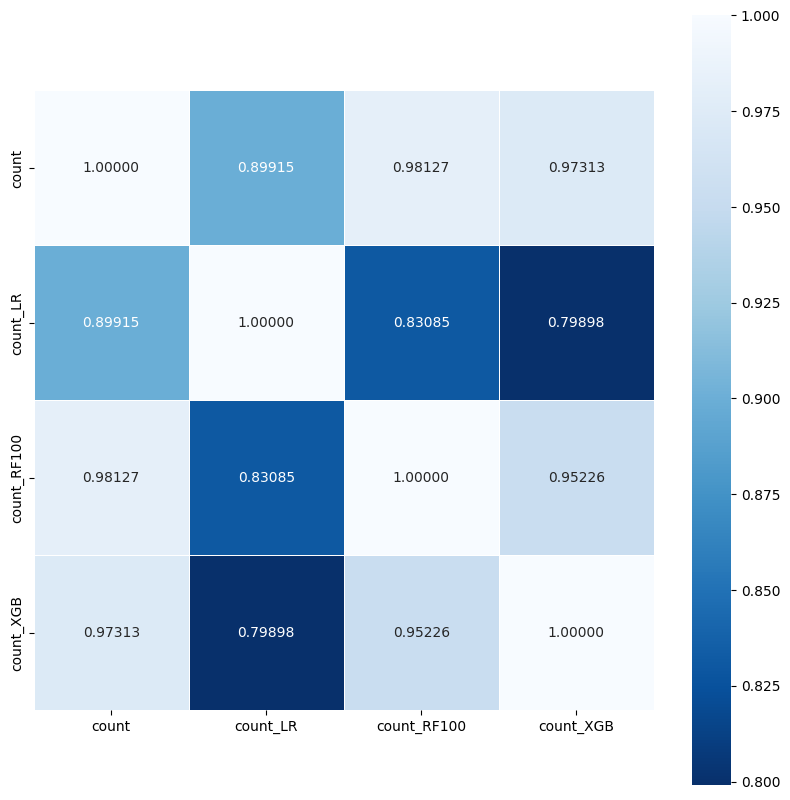

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(result.corr(), annot=True, fmt=".5f", linewidths=.5, square=True, cmap='Blues_r')